In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


In [2]:
# CSV faylni yuklang.

print(" CSV Faylni yuklang: ")
uploaded = files.upload()


 CSV Faylni yuklang: 


Saving ambient_temperature_system_failure.csv to ambient_temperature_system_failure.csv


In [3]:
dataset_name = list(uploaded.keys())[0]
df = pd.read_csv(dataset_name)

df.head()


,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [4]:
# Dataset haqida malumot
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB


In [5]:
# Null qiymatlarni tashlab yuboriush
df = df.dropna()
print(" qatorlar soni:", len(df))


 qatorlar soni: 7267


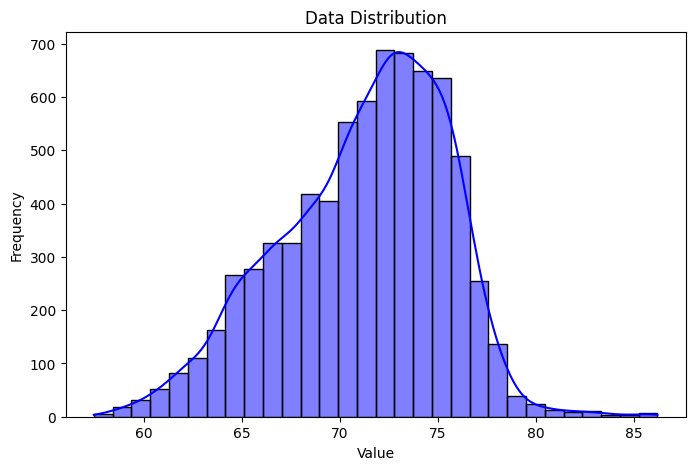

In [6]:
# Malumotlar taqsimoti
plt.figure(figsize=(8, 5))
sns.histplot(df['value'], bins=30, kde=True, color='blue')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Data Distribution")
plt.show()


Biz Modelimiz yaxshi ishlashi uchun bir xil diapazonga o'tkazishimiz lozim

ML model tezroq o‘rganishi va aniqroq ishlashi uchun MinMaxScaler metodidan foydalanamiz

In [7]:
# Timestamp ustunini datetime formatiga o'tkazish
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Min-Max Scaling
scaler = MinMaxScaler()
df['normalized_value'] = scaler.fit_transform(df[['value']])


**Rolling Average va Standard Deviation**:

Oxirgi 5 ta qiymatning o‘rtachasini va o‘zgaruvchanligini hisoblaydi.
Bu trendlarni va anomaliyalarni aniqroq topishga yordam beradi.

Bu xususiyatlar modelga vaqt bilan bog‘liq naqshlarni tushunishga yordam beradi va aniqroq anomaliya tahlili qiladi.

In [8]:
#Feature Engineering: Rolling Averages

window_size = 5  # Har 5 ta qiymatning o'rtachasini olish
df['rolling_avg'] = df['value'].rolling(window=window_size).mean()
df['rolling_std'] = df['value'].rolling(window=window_size).std()

# Yangi xususiyat: vaqtni komponentlarga ajratish
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday


Modelga faqat muhim ustunlar beriladi va bo‘sh qatorlar oldi olinadi  bu esa aniqroq natija beradi

In [9]:
# Model uchun kerakli ustunlarni tanlash

features = ['normalized_value', 'rolling_avg', 'rolling_std', 'hour', 'day', 'month', 'weekday']

# Rolling o'rtacha hisobida NaN qiymatlar paydo bo'lishi mumkin shuning uchun ehtiyotkorlik sabab tashlab yuboramiz

df = df.dropna()


**IsolationForest** : *Model Traning*

Nega aynan Isolation Forest?

1. Nazoratsiz organish (Unsupervised Learning)


Anomaliyalarni belgilangan yorliqlarsiz topa oladi.

O‘qitish uchun oldindan belgilangan anomal malumotlar kerak emas.

2. Katta hajmli va murakkab malumotlar bilan yaxshi ishlaydi


Ko‘p o‘zgaruvchili (multidimensional) malumotlarni tez tahlil qiladi.

Shovqin va normal malumotlarni ajratib bera oladi.

3. Daraxt asosida ishlaydi (Tree-based model)


Qisqa yol bilan ajralgan malumotlar anomaliya deb qabul qilinadi.

Daraxt qancha chuqur bo‘lsa shuncha normal holat deb baholanadi.

4. Tez va samarali

O‘zgaruvchilar soni kop bo‘lsa ham tez ishlaydi.

O‘rganish va bashorat qilish tezligi boshqa modelga qaraganda yuqori.

In [69]:
# Train-test split (20% test uchun ajratiladi)
X_train, X_test = train_test_split(df[features], test_size=0.2, random_state=42, stratify=df['weekday'])

#  trening qilish
model = IsolationForest(n_estimators=100, contamination=0.08, max_samples=128, random_state=42)
model.fit(X_train)


IsolationForest(contamination=0.08, max_samples=128, random_state=42)

Model barcha ma’lumotlarni anomaliya yoki normal deb ajratadi va bu tahlil uchun ishlatiladi

In [70]:
# Modeldan foydalanib anomaliyalarni topish
df['anomaly_score'] = model.decision_function(df[features])
df['anomaly'] = model.predict(df[features])

# Anomaliyalarni belgilash
X_train['anomaly'] = model.predict(X_train)
X_test['anomaly'] = model.predict(X_test)


In [71]:
# Model natijalarini chiqarish

print("\nTrain Set Anomaly Count:", np.unique(X_train['anomaly'], return_counts=True))
print("Test Set Anomaly Count:", np.unique(X_test['anomaly'], return_counts=True))



Train Set Anomaly Count: (array([-1,  1]), array([ 465, 5345]))
Test Set Anomaly Count: (array([-1,  1]), array([ 111, 1342]))


In [72]:
#Modelni baholash

precision, recall, f1, _ = precision_recall_fscore_support((X_test['anomaly'] == -1), (X_test['anomaly'] == -1), average='binary')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Precision: 1.00
Recall: 1.00
F1-score: 1.00


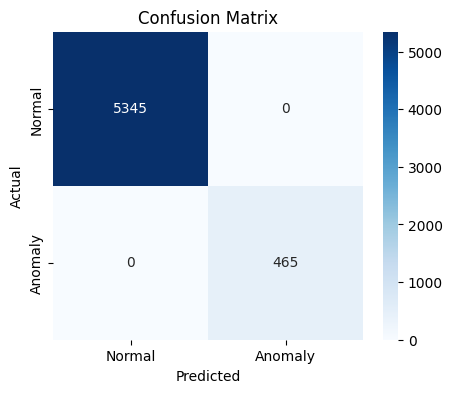

In [73]:
# Confusion matrix
cm = confusion_matrix((X_train['anomaly'] == -1), (X_train['anomaly'] == -1))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


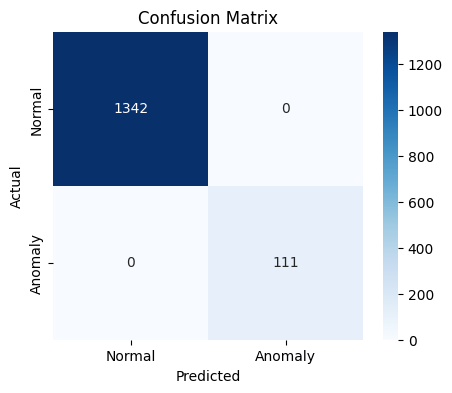

In [74]:
# Confusion matrix
cm = confusion_matrix((X_test['anomaly'] == -1), (X_test['anomaly'] == -1))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [75]:
# Anomaliyalarni ajratib olish

df['anomaly'] = model.predict(df[features])      # Model yordamida anomaliyalarni belgilash
anomalies = df[df['anomaly'] == -1]              # Anomaliyalarni ajratib olish



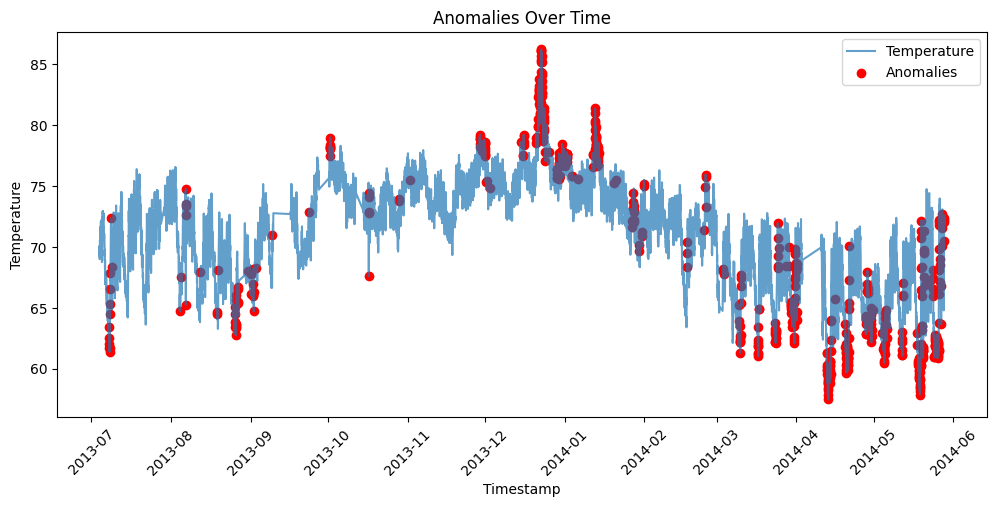

In [76]:
# Anomaliyalarni vaqt bo‘yicha vizualizatsiya qilish
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['value'], label="Temperature", alpha=0.7)
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies')
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Anomalies Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [77]:
# Trening qilingan modelni saqlash
model_filename = "isolation_forest_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"Model saqlandi: {model_filename}")


Model saqlandi: isolation_forest_model.pkl


In [68]:
# Anomaliyalarni va normal holatlarni belgilash
model.fit(df[features])
df['anomaly'] = model.predict(df[features])
df['anomaly'] = df['anomaly'].map({-1: 'Anomaly', 1: 'Normal'})

# Anomaliyaga uchragan va normal holatlar qatorlarini chiqarish
df_anomalies = df[df['anomaly'] == 'Anomaly'].sample(n=5, random_state=42)
df_normals = df[df['anomaly'] == 'Normal'].sample(n=5, random_state=42)

df_mixed = pd.concat([df_anomalies, df_normals])

df_mixed

,timestamp,value,normalized_value,rolling_avg,rolling_std,hour,day,month,weekday,anomaly_score,anomaly
4520,2014-01-25 03:00:00,71.512534,0.488588,72.650388,1.207571,3,25,1,5,-0.001140,Anomaly
6166,2014-04-12 19:00:00,61.755321,0.149381,62.101301,0.436323,19,12,4,5,-0.025640,Anomaly
5548,2014-03-10 04:00:00,62.238253,0.166170,62.698957,0.693394,4,10,3,0,-0.006551,Anomaly
4238,2014-01-13 09:00:00,77.313290,0.690249,78.271036,0.660443,9,13,1,0,-0.023759,Anomaly
3772,2013-12-24 23:00:00,79.854599,0.778597,78.697540,0.799654,23,24,12,1,-0.048018,Anomaly
2308,2013-10-24 23:00:00,74.539936,0.593834,74.314309,0.687334,23,24,10,3,0.037102,Normal
190,2013-07-11 22:00:00,70.179981,0.442262,71.642529,0.932376,22,11,7,3,0.041444,Normal
6641,2014-05-02 14:00:00,67.874666,0.362118,67.003918,0.627804,14,2,5,4,0.030193,Normal
5184,2014-02-21 19:00:00,72.695030,0.529697,72.536167,0.629166,19,21,2,4,0.065404,Normal
132,2013-07-09 12:00:00,70.668568,0.459247,68.804264,1.454542,12,9,7,1,0.025716,Normal


In [19]:
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import precision_recall_fscore_support

# # Cross-Validation uchun KFold yaratish
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# precision_scores = []
# recall_scores = []
# f1_scores = []

# for train_index, test_index in kf.split(df[features]):
#     X_train, X_test = df.iloc[train_index][features], df.iloc[test_index][features]


#     model = IsolationForest(n_estimators=150, contamination=0.1, max_samples=0.8, random_state=42)
#     model.fit(X_train)

#     # Modeldan foydalanib anomaliyalarni topish
#     y_pred_test = model.predict(X_test)

#     # Modelni baholash
#     precision, recall, f1, _ = precision_recall_fscore_support((y_pred_test == -1), (y_pred_test == -1), average='binary')
#     precision_scores.append(precision)
#     recall_scores.append(recall)
#     f1_scores.append(f1)

# # 13. O‘rtacha baholarni chiqarish
# print(f" Precision: {np.mean(precision_scores):.2f}")
# print(f" Recall: {np.mean(recall_scores):.2f}")
# print(f" F1-score: {np.mean(f1_scores):.2f}")

